In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import get_data
import matplotlib.pyplot as plt
import population_activity as pop
import helper_functions as hf
import analysis
import plots
import statistics_test as st

from IPython.display import display, HTML
def print_large(text):
    display(HTML(f"<span style='font-size: 20px;'>{text}</span>"))

c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [25]:
maps = [str(i) for i in np.arange(1, 13)] +  ['14', '15', '17', '19']
datapaths = ['D:/Antje_CA1/data_sig/170.h5', 'D:/Antje_CA1/data_sig/51004.h5', 'D:/Antje_CA1/data_sig/51007.h5', 'D:/Antje_CA1/data_sig/63.h5', 'D:/Antje_CA1/data_sig/64.h5', 'D:/Antje_CA1/data_sig/65.h5']

stability_neuron = []
for datapath in datapaths:
    stability_neuron.append(analysis.neuron_stability(datapath, 'Context1', ['0']+maps, remove_day_inactive=False))

c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\Ole\Documents\script\remapping\remapping\analysis.py:500: RuntimeWarning: Mean of empty slice
  hist_sorts_odd = [None] * (len(maps))
c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\Ole\Documents\script\remapping\remapping\analysis.py:500: RuntimeWarning: Mean of empty slice
  hist_sorts_odd = [None] * (len(maps))
c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\Ole\Document

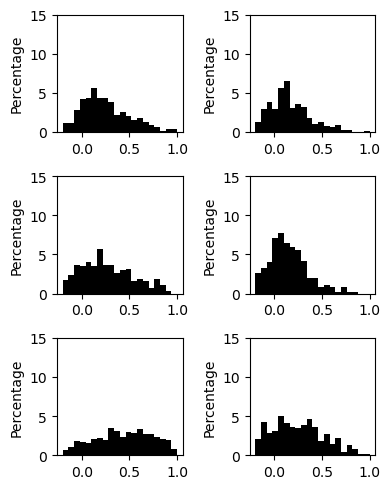

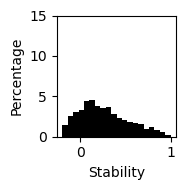

In [29]:
fig, axs = plt.subplots(3, 2, figsize=(4, 5))

for ax, stab in zip(axs.flatten(), stability_neuron):
    weights = np.ones_like(stab) / len(stab) * 100
    counts, bins, patches = ax.hist(stab, bins=20, range=(-0.2, 1), weights=weights, color='k')
    ax.set_ylim(0, 15)
    ax.set_ylabel('Percentage')

plt.tight_layout()
plt.show()

all_stability = np.concatenate(stability_neuron)
fig, ax = plt.subplots(figsize=(2, 2))
weights = np.ones_like(all_stability) / len(all_stability) * 100
counts, bins, patches = ax.hist(all_stability, bins=20, range=(-0.2, 1), weights=weights, color='k')
ax.set_ylim(0, 15)
ax.set_ylabel('Percentage')
ax.set_xlabel('Stability')
plt.tight_layout()
plt.show()

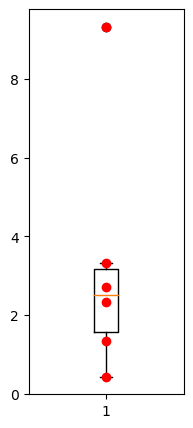

In [24]:
above60 = [sum(stability > 0.7) / len(stability) * 100 for stability in stability_neuron]
fig, ax = plt.subplots(figsize=(2, 5))
ax.boxplot(above60)
ax.plot([1] * len(above60), above60, 'ro')
plt.show()

In [4]:
def analyze_data_common(datapath, reference, maps, analysis_type, method='subspace', compute_day11_12=False, 
                        transients=False, dim_red=False, max_dim=4, standardize='stand'):
    def get_analysis_function(analysis_type):
        if analysis_type == 'population_geometry':
            return analysis.populationgeometry, analysis.populationgeometry_context
        elif analysis_type == 'topology':
            return analysis.topology_analysis, analysis.topology_analysis_context


    analysis_func, context_func = get_analysis_function(analysis_type)

    def apply_analysis(func, *args):
        if analysis_type == 'population_geometry':
            return func(*args, method=method)
        else:
            return func(*args, max_dim=max_dim)

    stable=analysis.neuron_stability(datapath, 'Context1', [reference] + maps, transients=transients, dim_red=dim_red, standardize=standardize, remove_day_inactive=False)
    hists = analysis.sort_maps_from_reference_AK(datapath, 'Context1', reference=reference, maps=maps, 
                                                 reference_type='no_reference', hist='hist', transients=transients, dim_red=dim_red, 
                                                 standardize=standardize, remove_day_inactive=False, remove_stable=stable)
    g = apply_analysis(analysis_func, hists)

    global_seeds = [1,2,3,4,5]
    simu_g_list = []
    for seed in global_seeds:
        simu_drift = analysis.simulate_drift(datapath, session='0', Context='Context1', days=len(maps)+1, 
                                             drift_type='circular', dim_red=dim_red, standardize=standardize, odd_even=True,
                                               global_seed=seed, active_days=[reference]+maps, remove_day_inactive=True,
                                                 max_remap_prob=0.5, amplitude_drift_prob=0.3, amplitude_change_scale=0.5)
        simu_g = apply_analysis(analysis_func, simu_drift['maps'])
        simu_g_list.append(simu_g)
    simu_g_array = np.array(simu_g_list)
    simu_g = np.mean(simu_g_array, axis=0)

    if analysis_type == 'population_geometry':      
        hist_odd, hist_even = analysis.sort_maps_from_reference_within_session_AK(datapath, 'Context1', maps=maps, 
                                                                                  transients=transients, dim_red=dim_red, 
                                                                                  standardize=standardize, remove_day_inactive=False)
        g_odd_even1 = apply_analysis(context_func, hist_odd, hist_even)
        
        shuff1, shuff2 = analysis.shuffle_two_sessions_hist(datapath, '0', '19', 'Context1', dim_red=dim_red, 
                                                            remove_inactive=[reference]+maps, standardize=standardize, 
                                                            remove_day_inactive=False)
        g_shuff1 = apply_analysis(context_func, [shuff1], [shuff2])

        
        g = (g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))
        simu_g = (simu_g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))

    return g, simu_g


def collect_data(datapaths, reference, maps, analysis_type, method='subspace', compute_day11_12=False,
                  transients=False, dim_red=False, max_dim=3, standardize='stand'):
    all_data = []
    for datapath in datapaths:
        data = analyze_data_common(datapath, reference, maps, analysis_type, method=method, 
                                   compute_day11_12=compute_day11_12, transients=transients, 
                                   dim_red=dim_red, max_dim=max_dim, standardize=standardize)
        all_data.append(data)
    return all_data

if __name__ == "__main__":
    datapaths = ['D:/Antje_CA1/data_sig/170.h5', 'D:/Antje_CA1/data_sig/51004.h5', 'D:/Antje_CA1/data_sig/51007.h5',
                'D:/Antje_CA1/data_sig/63.h5', 'D:/Antje_CA1/data_sig/64.h5', 'D:/Antje_CA1/data_sig/65.h5']
    transients = False
    dim_red = False
    max_dim = 4

    reference = '0'
    maps = [str(i) for i in np.arange(1, 13)] +  ['14', '15', '17', '19']
    forward_data_pop_geometry_subspace = collect_data(datapaths, reference, maps, 
                                                      'population_geometry', method='subspace', compute_day11_12=False, 
                                                      transients=transients, dim_red=dim_red, standardize='stand')
    forward_data_pop_geometry_angles = collect_data(datapaths, reference, maps, 'population_geometry', method='angles', 
                                                    compute_day11_12=False, transients=transients, dim_red=dim_red, standardize='stand')
    forward_data_topology = collect_data(datapaths, reference, maps, 'topology', compute_day11_12=False, 
                                         transients=transients, dim_red=dim_red, max_dim=max_dim, standardize='stand')


c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\Ole\Documents\script\remapping\remapping\analysis.py:495: RuntimeWarning: Mean of empty slice
  mean_correlations = np.nanmean(all_correlations, axis=1)
c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\Ole\Documents\script\remapping\remapping\analysis.py:495: RuntimeWarning: Mean of empty slice
  mean_correlations = np.nanmean(all_correlations, axis=1)
c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantIn

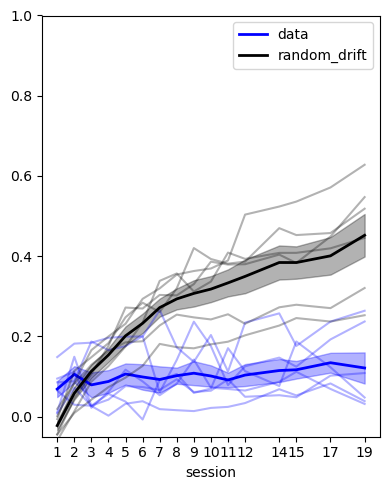

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,0.954429,15,75,0.063629,24.063828,1.105091e-22,0.000020,0.481341,0.174211
1,condition,1.265998,1,5,1.265998,44.101298,1.166964e-03,0.001167,0.551771,1.000000
2,time * condition,0.659134,15,75,0.043942,30.246059,1.000819e-25,0.000003,0.390584,0.188155


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,6.6460,0.0012,0.0186,*,2.7132,Cohen's d,0.0688,-0.0223,0.0911,0.0336,6,True,0.7540
1,T2,C1,C2,t-test,1.9799,0.1046,1.0000,,0.8083,Cohen's d,0.1056,0.0582,0.0473,0.0586,6,True,0.5203
2,T3,C1,C2,t-test,-1.4464,0.2077,1.0000,,-0.5905,Cohen's d,0.0792,0.1132,-0.0340,0.0576,6,True,0.7502
3,T4,C1,C2,t-test,-2.5348,0.0522,0.8356,,-1.0348,Cohen's d,0.0877,0.1538,-0.0661,0.0639,6,True,0.4647
4,T5,C1,C2,t-test,-2.8480,0.0359,0.5745,,-1.1627,Cohen's d,0.1064,0.2015,-0.0951,0.0818,6,True,0.2271
5,T6,C1,C2,t-test,-4.0359,0.0100,0.1594,,-1.6476,Cohen's d,0.0990,0.2327,-0.1337,0.0812,6,True,0.0744
6,T7,C1,C2,t-test,-5.1713,0.0036,0.0568,,-2.1112,Cohen's d,0.0927,0.2719,-0.1792,0.0849,6,True,0.9431
7,T8,C1,C2,t-test,-6.5603,0.0012,0.0197,*,-2.6782,Cohen's d,0.1021,0.2935,-0.1914,0.0715,6,True,0.6569
8,T9,C1,C2,t-test,-5.8562,0.0021,0.0329,*,-2.3908,Cohen's d,0.1084,0.3073,-0.1989,0.0832,6,True,0.6322
9,T10,C1,C2,t-test,-5.9875,0.0019,0.0298,*,-2.4444,Cohen's d,0.1014,0.3180,-0.2166,0.0886,6,True,0.6785


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.023558,15,0.001571,0.899492,0.56767,0.052431,0.179464
1,Error,0.130951,75,0.001746,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,1.590005,15,0.106000,45.087785,2.558614e-31,0.725143,0.120324
1,Error,0.176323,75,0.002351,NaN,NaN,NaN,NaN


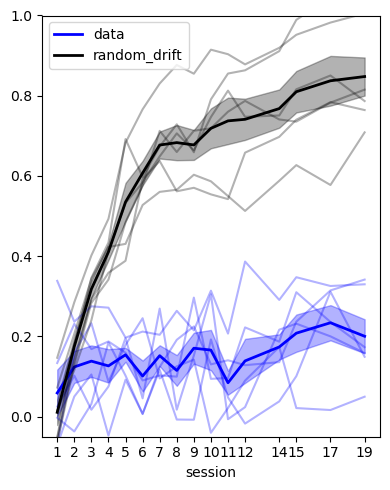

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,3.484300,15,75,0.232287,43.537663,8.133336e-31,9.025613e-09,0.631139,0.238439
1,condition,9.740916,1,5,9.740916,142.581384,7.261951e-05,7.261951e-05,0.827094,1.000000
2,time * condition,2.159487,15,75,0.143966,22.370757,9.672451e-22,1.180274e-05,0.514673,0.193314


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,1.2577,0.2640,1.0000,,0.5134,Cohen's d,0.0591,0.0108,0.0483,0.0941,6,True,0.7930
1,T2,C1,C2,t-test,-1.9561,0.1078,1.0000,,-0.7986,Cohen's d,0.1240,0.1751,-0.0511,0.0640,6,True,0.4830
2,T3,C1,C2,t-test,-6.4085,0.0014,0.0220,*,-2.6163,Cohen's d,0.1384,0.3180,-0.1796,0.0686,6,True,0.2102
3,T4,C1,C2,t-test,-6.4687,0.0013,0.0210,*,-2.6408,Cohen's d,0.1266,0.4108,-0.2842,0.1076,6,True,0.7973
4,T5,C1,C2,t-test,-7.4012,0.0007,0.0113,*,-3.0215,Cohen's d,0.1542,0.5352,-0.3810,0.1261,6,True,0.5560
5,T6,C1,C2,t-test,-13.6297,3.8120e-05,0.0006,***,-5.5643,Cohen's d,0.1012,0.6072,-0.5060,0.0909,6,True,0.0604
6,T7,C1,C2,t-test,-13.3458,4.2247e-05,0.0007,***,-5.4484,Cohen's d,0.1520,0.6771,-0.5251,0.0964,6,True,0.5306
7,T8,C1,C2,t-test,-14.6087,2.7145e-05,0.0004,***,-5.9640,Cohen's d,0.1152,0.6831,-0.5680,0.0952,6,True,0.5512
8,T9,C1,C2,t-test,-9.0833,0.0003,0.0043,**,-3.7082,Cohen's d,0.1706,0.6774,-0.5067,0.1367,6,True,0.8325
9,T10,C1,C2,t-test,-7.1990,0.0008,0.0129,*,-2.9390,Cohen's d,0.1660,0.7187,-0.5527,0.1881,6,True,0.6541


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.190268,15,0.012685,1.762417,0.056701,0.163795,0.233136
1,Error,0.539793,75,0.007197,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,5.453519,15,0.363568,79.494342,1.030479e-39,0.83662,0.134617
1,Error,0.343013,75,0.004574,NaN,NaN,NaN,NaN


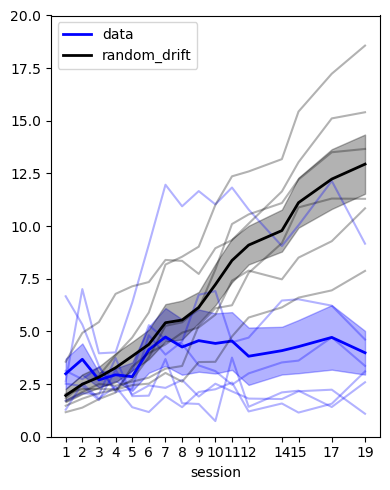

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,729.056574,15,75,48.603772,21.974294,1.637486e-21,0.001153,0.371752,0.098476
1,condition,361.668612,1,5,361.668612,6.825998,4.751682e-02,0.047517,0.226930,1.000000
2,time * condition,461.524247,15,75,30.768283,17.536930,1.038018e-18,0.000063,0.272510,0.186034


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,2.1091,0.0887,1.0000,,0.8610,Cohen's d,2.9898,1.9578,1.0320,1.1986,6,True,0.4256
1,T2,C1,C2,wilcoxon,1.0000,0.0625,1.0000,,0.8131,r,3.6779,2.4954,1.1825,1.7835,6,False,0.0056
2,T3,C1,C2,t-test,-0.2572,0.8073,1.0000,,-0.1050,Cohen's d,2.6975,2.8272,-0.1297,1.2351,6,True,0.8241
3,T4,C1,C2,t-test,-0.3362,0.7504,1.0000,,-0.1372,Cohen's d,2.9411,3.2753,-0.3343,2.4358,6,True,0.1665
4,T5,C1,C2,t-test,-0.8779,0.4202,1.0000,,-0.3584,Cohen's d,2.8497,3.8260,-0.9763,2.7238,6,True,0.3241
5,T6,C1,C2,wilcoxon,6.0000,0.4375,1.0000,,0.3852,r,4.1321,4.3853,-0.2532,2.8254,6,False,0.0106
6,T7,C1,C2,t-test,-0.4133,0.6965,1.0000,,-0.1687,Cohen's d,4.7352,5.4129,-0.6777,4.0172,6,True,0.2541
7,T8,C1,C2,wilcoxon,6.0000,0.4375,1.0000,,0.3852,r,4.2603,5.5400,-1.2798,3.5191,6,False,0.0446
8,T9,C1,C2,t-test,-0.9959,0.3650,1.0000,,-0.4066,Cohen's d,4.5626,6.1425,-1.5799,3.8859,6,True,0.2577
9,T10,C1,C2,t-test,-1.8266,0.1273,1.0000,,-0.7457,Cohen's d,4.4298,7.2239,-2.7940,3.7469,6,True,0.9659


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,43.290819,15,2.886055,1.263439,0.246806,0.054608,0.12856
1,Error,171.321409,75,2.284285,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,1147.290003,15,76.486000,45.471991,1.931387e-31,0.703903,0.099346
1,Error,126.153483,75,1.682046,NaN,NaN,NaN,NaN


In [35]:
# Subspace geometry analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: SUBSPACE angles')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_pop_geometry_subspace]
simu_g = [data[1] for data in forward_data_pop_geometry_subspace]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-0.05, 1], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData: ONE-WAY RM ANOVA')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift: oNE-WAY RM ANOVA')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))

# Angles analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: Edge angles')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_pop_geometry_angles]
simu_g = [data[1] for data in forward_data_pop_geometry_angles]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-0.05, 1], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData:')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift:')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))

# Topology analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: Persistent homology')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_topology]
simu_g = [data[1] for data in forward_data_topology]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[0, 20], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData:')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift:')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))